In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
%cd ..

/cis/home/dpacker/my_documents/dark-matter-halos-2


In [30]:
from pathlib import Path
from src.pipeline.pipeline import *
from src.summarize.train_test import *
from jax import numpy as jnp
import jax
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
root_path = Path(".")
data_path = root_path / "data"
gen_data_path = root_path / "generated_data_extended"
results_path = root_path / "results" / "cross_validation"

features_and_targets = jnp.load(gen_data_path / "features_and_targets.npz")
subsampled_data = jnp.load(gen_data_path / "kmeans_subsampled_n1_s75.npz")

n_halos = 500

# Generating the train-test split: keep fixed seed of 0
rng = jax.random.PRNGKey(0)
prop_train = 0.75
prop_test = 0.25

n_train = int(n_halos * prop_train)
n_test = n_halos - n_train

train_indices = np.loadtxt(gen_data_path / "train_indices.txt", dtype=int)
test_indices = np.loadtxt(gen_data_path / "test_indices.txt", dtype=int)

In [20]:
t = 0
problem_context = ProblemContext(
    points=subsampled_data["points"][:, t],
    weights=subsampled_data["weights"][:, t],
    velocities=subsampled_data["velocities"][:, t],
    masses=jnp.log10(features_and_targets["Group_M_Crit200"]),
    concentrations=features_and_targets["SubhaloC200"],
    labels=jnp.log10(features_and_targets["StellarMass"] * 1e10 / 0.677),
)
hyperparametrization = Hyperparametrization(
    rescale_strategy=["unitless"],
    p=1.0,
    q=1.0,
    tau=10.0,
    alpha_C=np.concatenate([np.array([0]), np.logspace(-2, 2, num=11, base=10, endpoint=True)]),
    alpha_M=1.0,
    alpha_SLB=np.concatenate([np.array([0]), np.logspace(-2, 2, num=11, base=10, endpoint=True)]),
    n_neighbors=np.arange(1, 40),
)

losses, loss_array = get_train_test_losses(problem_context, hyperparametrization, train_indices, test_indices, inner_pbar=True)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

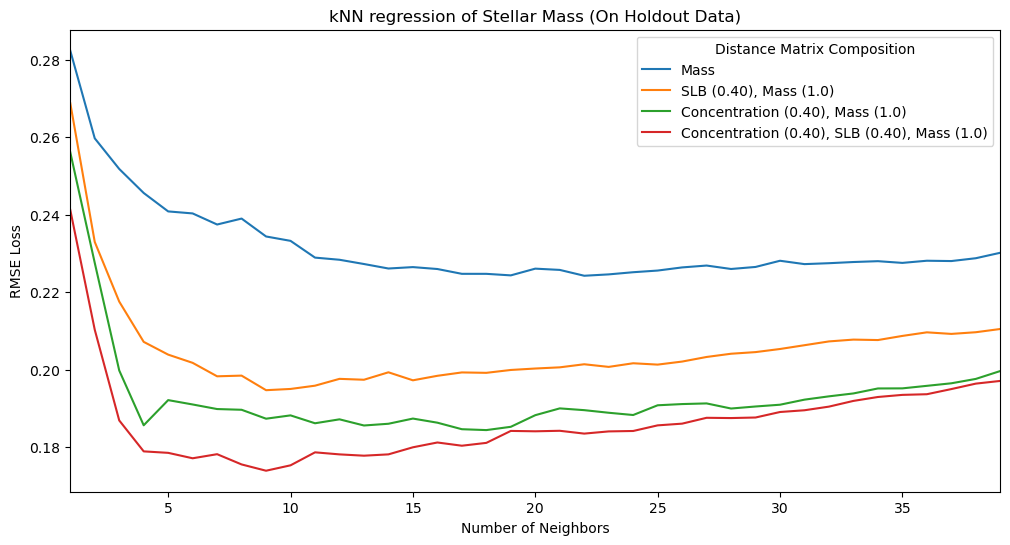

In [35]:
fig, ax = plt.subplots(figsize=(12, 6))
ax: plt.Axes = ax
ix = 5
ax.plot(hyperparametrization.n_neighbors, loss_array[0, 0], label="Mass")
ax.plot(
    hyperparametrization.n_neighbors,
    loss_array[0, ix],
    label=f"SLB ({hyperparametrization.alpha_SLB[ix]:.2f}), Mass (1.0)",
)
ax.plot(
    hyperparametrization.n_neighbors,
    loss_array[ix, 0],
    label=f"Concentration ({hyperparametrization.alpha_C[ix]:.2f}), Mass (1.0)",
)
ax.plot(
    hyperparametrization.n_neighbors,
    loss_array[ix, ix],
    label=f"Concentration ({hyperparametrization.alpha_C[ix]:.2f}), SLB ({hyperparametrization.alpha_SLB[ix]:.2f}), Mass (1.0)",
)

ax.legend(title="Distance Matrix Composition")
ax.set(
    xlabel="Number of Neighbors",
    ylabel="RMSE Loss",
    title="kNN regression of Stellar Mass (On Holdout Data)",
    xlim=(
        hyperparametrization.n_neighbors.min(),
        hyperparametrization.n_neighbors.max(),
    ),
)

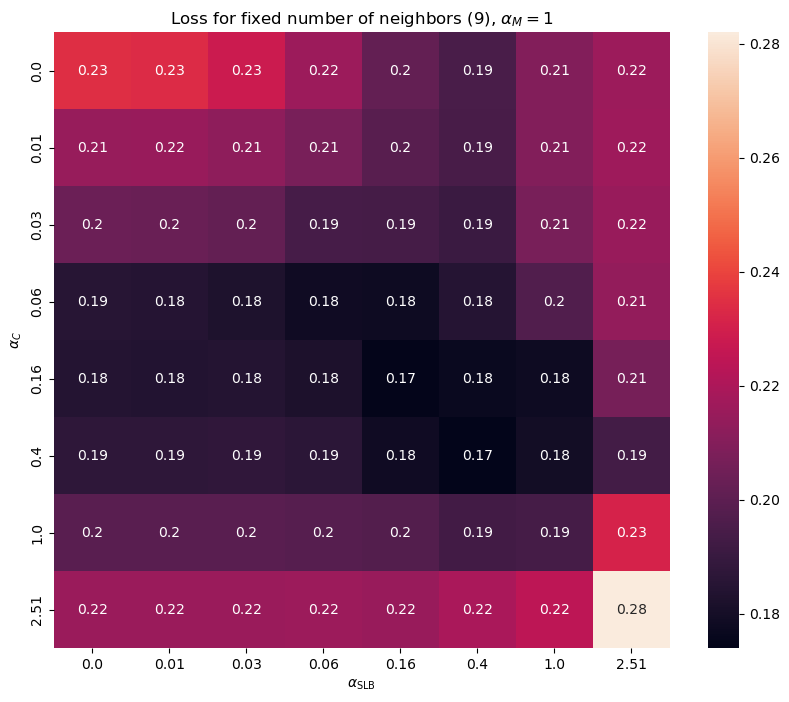

In [51]:
lim = 8
neighbors_ix = 8
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    loss_array[:lim, :lim, neighbors_ix],
    yticklabels=np.round(hyperparametrization.alpha_C[:lim], 2),
    xticklabels=np.round(hyperparametrization.alpha_SLB[:lim], 2),
    annot=True,
    ax=ax,
)
ax.set(
    aspect="equal",
    title=f"Loss for fixed number of neighbors ({hyperparametrization.n_neighbors[neighbors_ix]}), " + r"$\alpha_{M}=1$",
    ylabel=r"$\alpha_C$",
    xlabel=r"$\alpha_{\rm SLB}$",
);